# Small models: Road to the top, Part 2

Identify the type of disease present in paddy leaf images
https://www.kaggle.com/competitions/paddy-disease-classification
    
Series

- First Steps: Road to the Top, Part 1
- Small models: Road to the top, Part 2

# Outline

- Setup installs fastkaggle, fastai, timm
- Looking at the data involves reviewing train/val images, shapes, labels, valcounts of labels
- Baseline model

In [1]:
# %pip install kaggle -qqq

# %pip install fastkaggle -qqq

# %pip install nbprocess -qqq

In [2]:
#%pip install fastai "timm>=0.6.2.dev0"

In [3]:
# %pip install nbdev -qqq

In [4]:
from fastcore.all import *

# Going faster

Head to the above competition url and join the competition. Download kaggle.json file to your local (since we are running it on local).

In [5]:
from fastcore.utils import *

In [6]:
from fastkaggle import *
#from kaggle import api

In [7]:
import os

os.environ['KAGGLE_USERNAME'] = 'msivanes'
os.environ['KAGGLE_KEY'] = '86a921b9fbb91510e39e32676566a0fb'

In [8]:
# Get a path to data for `competition`, downloading it if needed
path = 'paddy-disease-classification'
setup_comp(path, install='nbprocess fastai "timm>=0.6.2.dev0"')

Path('paddy-disease-classification')

Alternatively I downloaded the competition dataset using the below command.

In [9]:
# !kaggle competitions download -c paddy-disease-classification

In [10]:
import os, zipfile

fname='paddy-disease-classification'
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
downloaded = Path('./train_images').exists() 

if not iskaggle and Path(f'{fname}.zip').exists() and not downloaded:
    downloaded=True
    ref = zipfile.ZipFile(f'{fname}.zip', 'r')
    ref.extractall()
    ref.close()

In [11]:
path = Path('.')

Import fastai vision for image classification. set_seed for reproducibility for competition but generally when doing analysis you may want to see different data, jph00 does not recommend setting seed.

In [12]:
from fastai.vision.all import *
import timm
set_seed(42)
path.ls()

(#10) [Path('train_images'),Path('paddy-disease-classification'),Path('test_images'),Path('011_paddy_baseline.ipynb'),Path('sample_submission.csv'),Path('train.csv'),Path('.ipynb_checkpoints'),Path('012_paddy_small_models.ipynb'),Path('sml'),Path('paddy-disease-classification.zip')]

Trick to iterate much more quickly - What we can do is to simply resize all the images to half their height and width -- which reduces their number of pixels 4x. This should mean an around 4x increase in performance for training small models.

We have images in `train_images` 

In [13]:
trn_path = Path('sml')

In [14]:
doc(resize_images)

In [15]:
if False:
    resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

In [16]:
trn_path.ls()

(#10) [Path('sml/hispa'),Path('sml/bacterial_leaf_blight'),Path('sml/brown_spot'),Path('sml/dead_heart'),Path('sml/downy_mildew'),Path('sml/tungro'),Path('sml/bacterial_panicle_blight'),Path('sml/blast'),Path('sml/bacterial_leaf_streak'),Path('sml/normal')]

In [17]:
files = get_image_files(trn_path); files

(#10407) [Path('sml/hispa/108447.jpg'),Path('sml/hispa/104335.jpg'),Path('sml/hispa/104967.jpg'),Path('sml/hispa/109394.jpg'),Path('sml/hispa/104945.jpg'),Path('sml/hispa/105222.jpg'),Path('sml/hispa/107313.jpg'),Path('sml/hispa/108550.jpg'),Path('sml/hispa/104501.jpg'),Path('sml/hispa/102495.jpg')...]

Let's look at a single image

In [18]:
img = PILImage.create(files[0])

In [19]:
print(img.size)

(192, 256)


This will give us 192x256 images.

we can see the thumbnail of the image

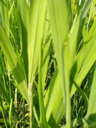

In [20]:
img.to_thumb(128)

Check the sizes of all images in train

In [21]:
def img_size(o): return PILImage.create(o).size

In [22]:
# %time sizes = files.map(img_size)

Trick: use fastcore `parallel` utility to make the operation faster. This Applies func in parallel to items, using n_workers

In [23]:
from fastcore.parallel import *

In [24]:
%time sizes = parallel(img_size, files, n_workers=8)

CPU times: user 2.6 s, sys: 547 ms, total: 3.15 s
Wall time: 13 s


In [25]:
pd.Series(sizes).value_counts()

(192, 256)    10403
(256, 192)        4
dtype: int64

Except for 4 images, all are of the same size (192, 256). Always resize all images to be of the same size else fastai cannot create batches.

Using the factory method from ImageDataLoaders to load the images from folders

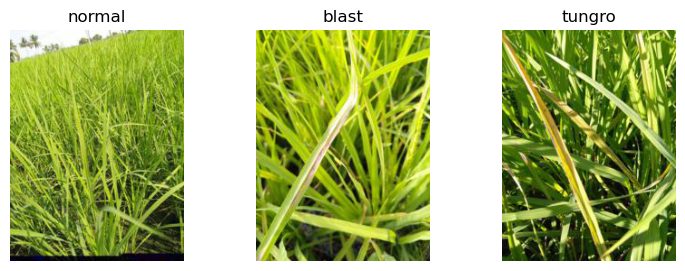

In [26]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
        item_tfms=Resize((256, 192)))

dls.show_batch(max_n=3)

The goal is to experiment with different arch, image processing approaches (item & batch transforms)

In [29]:
def train(arch, item, batch, epoch=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epoch, 0.01)
    return learn

## resnet26d

In [30]:
learn = train('resnet26d', item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.907379,1.476265,0.467564,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.268577,0.975477,0.322922,00:16
1,1.023625,0.747039,0.252283,00:15
2,0.698251,0.507371,0.164344,00:16
3,0.539128,0.390485,0.121576,00:16
4,0.461516,0.393460,0.125901,00:16


# A ConvNext model

In [31]:
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [31]:
arch = 'convnext_small_in22k'

In [32]:
learn = train(arch, item=Resize(192, method='squish'), batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.298847,0.902256,0.293609,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.636655,0.427294,0.137914,00:30
1,0.492123,0.391858,0.124459,00:30
2,0.328616,0.238805,0.079289,00:30
3,0.187501,0.158445,0.047093,00:30
4,0.127121,0.144844,0.042287,00:31


# Preprocessing experiments

## Cropping
Using crop which is fastai default instead of squish

In [33]:
learn = train(arch, item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.369634,0.820531,0.261413,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.675867,0.506613,0.163864,00:31
1,0.536475,0.398214,0.121096,00:31
2,0.370453,0.244928,0.075925,00:30
3,0.235688,0.190085,0.057184,00:31
4,0.170916,0.168722,0.053820,00:31


## Padding

This keeps all the original image without transforming it.

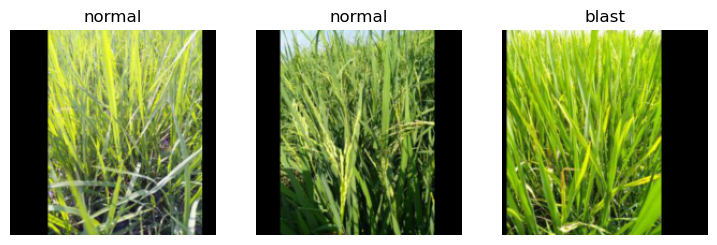

In [36]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [37]:
learn = train(arch, item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(171, 128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.278076,0.785059,0.260452,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.658092,0.591048,0.194618,00:35
1,0.517776,0.364807,0.117251,00:36
2,0.334928,0.222028,0.065834,00:36
3,0.199459,0.174891,0.052379,00:37
4,0.138177,0.160829,0.046132,00:36


# Test time augmentation

> During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

In [39]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [40]:
error_rate(preds, targs)

TensorBase(0.0461)

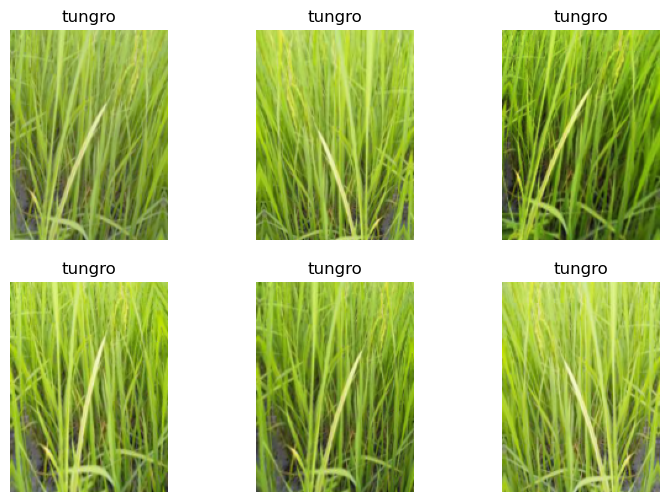

In [41]:
learn.dls.train.show_batch(max_n=6, unique=True)

`tta()` allows to get the avg of predictions from all the augmented versions of each image along with the unaugmented original

In [42]:
tta_preds,_ = learn.tta(dl=valid)

In [43]:
error_rate(tta_preds, targs)

TensorBase(0.0423)

# Scaling Up

scaling to larger images and more epochs

In [44]:
trn_path = path/'train_images'

In [46]:
learn = train(arch, epoch=12, item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(256, 192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.147902,0.644333,0.205670,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.540011,0.330859,0.114849,01:22
1,0.396755,0.279262,0.084094,01:23
2,0.350625,0.333167,0.093705,01:23
3,0.297759,0.301016,0.089861,01:23
4,0.228875,0.231286,0.061028,01:23
5,0.199692,0.249799,0.076406,01:23
6,0.118367,0.144494,0.039404,01:23
7,0.099989,0.151369,0.037482,01:24
8,0.071397,0.120020,0.033157,01:23
9,0.065152,0.108850,0.025469,01:23


In [47]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0240)

# Submission

In [48]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [59]:
tst_files = get_image_files(path/'test_images').sorted()

In [60]:
tst_files

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [61]:
test_dl = dls.test_dl(tst_files)

In [62]:
preds,_ = learn.tta(dl=test_dl)

indices of the largest probability prediction in each row provides the index of predicted disearch. `argmax` helps to get that. 

In [63]:
idxs = preds.argmax(dim=1)

In [64]:
# mapping = dict(enumerate(dls.vocab))
# mapping
vocab = np.array(learn.dls.vocab)

In [65]:
results = pd.Series(vocab[idxs], name='idxs')
results

0            hispa
1           normal
2           normal
3            blast
4            blast
           ...    
3464    dead_heart
3465        normal
3466        normal
3467         blast
3468    dead_heart
Name: idxs, Length: 3469, dtype: object

In [66]:
ss['label'] = results

In [67]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,normal
200004.jpg,blast
200005.jpg,blast
200006.jpg,normal
200007.jpg,dead_heart
200008.jpg,normal
200009.jpg,hispa


In [68]:
!kaggle competitions submit -f 'subm.csv' -m 'convnext_small_in22k 256x192 12 epoch tta' paddy-disease-classification

100%|██████████████████████████████████████| 67.5k/67.5k [00:00<00:00, 69.8kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification